# Example on Mixed Constraint: France Population Transport

In this notebook, we will consider the case where we have both the total population constraint and the barrier constraint. The motivation is as follows. Let's say we have a data on population density at two time points and the aggregated total population data between them in a certain region. Then, to find the geodesic that honors the aggregate data, we can impose the total mass constraint. On top of that, to honor the shape of the region, we can impose the barrier constraint where the barrier is the outside of the region.

Here, we will use the data on French population from INSEE. In particular, you need the following two files:
- `base-pop-historiques-1876-2020.xlsx` from [https://github.com/Antoberge/mapcommune/tree/main/data](here)
- `ADE_4-0_GPKG_WGS84G_FRA-ED2025-08-15.gpkg` from [https://geoservices.ign.fr/adminexpress](here). More directly, [this link](https://data.geopf.fr/telechargement/download/ADMIN-EXPRESS/ADMIN-EXPRESS_4-0__GPKG_WGS84G_FRA_2025-08-15/ADMIN-EXPRESS_4-0__GPKG_WGS84G_FRA_2025-08-15.7z) works. If this specific version has expried, the latest available version might work, but we did not test for that and the file names recorded in `GPKG` in the code must be changed.

Both files should be put under the `paper/input` folder.

In [1]:
# The department to use for the example
DEP_CODE = "01" # 01 for Ain department

In [2]:
# Import necessary libraries & import data
import numpy as np, pandas as pd, geopandas as gpd, fiona
from shapely.geometry import box
# Optional (faster multiply & small Gaussian smoothing):
try:
    from scipy.sparse import coo_matrix, csr_matrix
    from scipy.ndimage import gaussian_filter
    SCIPY = True
except Exception:
    SCIPY = False

In [3]:
# Run to obtain processed density data & obstacle data
EXCEL = "input/base-pop-historiques-1876-2020.xlsx"
GPKG  = "input/ADE_4-0_GPKG_WGS84G_FRA-ED2025-08-15.gpkg"
YEARS = sorted(list(range(1876, 1912, 5)) + [1936, 1931, 1926, 1921])
TARGET_CRS = "EPSG:2154"
N = 64   # fits your compute budget

def find_commune_layer(gpkg):
    L = [L for L in fiona.listlayers(gpkg) if L.lower() in {"commune","communes"}]
    if not L: raise RuntimeError("COMMUNE layer not found.")
    return L[0]

def load_communes(gpkg, dep="01"):
    L = find_commune_layer(gpkg)
    com = gpd.read_file(gpkg, layer=L).to_crs(TARGET_CRS)
    code_cols = ["INSEE_COM","insee_com","code_insee","CODE_INSEE","CODGEO","codgeo","insee"]
    cc = next((c for c in code_cols if c in com.columns), None)
    if cc is None: raise RuntimeError("No commune INSEE code column in GPKG.")
    com["CODGEO"] = com[cc].astype(str).str.zfill(5)
    dep_communes = com[com["CODGEO"].str[:2]==dep].copy()
    if dep_communes.empty: raise RuntimeError(f"Department {dep} subset is empty; check GPKG.")
    return dep_communes

def build_grid_and_barrier_polygons(dep_communes, N):
    """Return (minx, miny, dx, dy, barrier[N,N], grid_gdf with cell polygons & indices)."""
    dep_communes = dep_communes.to_crs(TARGET_CRS)
    minx, miny, maxx, maxy = dep_communes.total_bounds
    dx = (maxx - minx)/N; dy = (maxy - miny)/N

    dept_poly = dep_communes.unary_union

    cells = []
    for iy in range(N):
        y0 = miny + iy*dy; y1 = y0 + dy
        for ix in range(N):
            x0 = minx + ix*dx; x1 = x0 + dx
            geom = box(x0, y0, x1, y1)
            allowed = geom.intersects(dept_poly)  # allow partial-overlap boundary cells
            cells.append({"iy": iy, "ix": ix, "cell_id": iy*N + ix, "allowed": allowed, "geometry": geom})

    grid = gpd.GeoDataFrame(cells, crs=TARGET_CRS)
    barrier = ~grid["allowed"].to_numpy().reshape(N, N)  # True = forbidden
    return (minx, miny, dx, dy, barrier, grid)

def build_area_fraction_matrix(dep_communes, grid):
    """
    Build sparse A (num_cells × num_communes) where A[i,j] = area(cell_i ∩ commune_j) / area(commune_j).
    Also returns the communes in a fixed order & their CODGEO list.
    """
    com = dep_communes[["CODGEO", "geometry"]].copy()
    com["area"] = com.geometry.area.values
    # spatial index over grid cells to avoid all-pairs
    sidx = grid.sindex

    rows, cols, vals = [], [], []
    for j, (geom_j, area_j) in enumerate(zip(com.geometry, com["area"])):
        if area_j <= 0:
            continue
        cand = list(sidx.query(geom_j, predicate="intersects"))
        if not cand:
            continue
        inter = grid.geometry.iloc[cand].intersection(geom_j).area.values
        mask = inter > 0
        if mask.any():
            rows.extend([grid["cell_id"].iloc[c] for c, m in zip(cand, mask) if m])
            cols.extend([j] * int(mask.sum()))
            vals.extend((inter[mask] / area_j).tolist())

    if SCIPY:
        A = csr_matrix((vals, (rows, cols)), shape=(len(grid), len(com)))
    else:
        # Fallback dense (OK at N<=96 and ~400 communes, but uses more RAM)
        A = np.zeros((len(grid), len(com)), dtype=float)
        A[np.array(rows), np.array(cols)] = np.array(vals)

    # Sanity: area fractions per commune should sum to ~1
    if SCIPY:
        col_sums = np.array(A.sum(axis=0)).ravel()
    else:
        col_sums = A.sum(axis=0)
    max_dev = float(np.max(np.abs(col_sums - 1)))
    if max_dev > 1e-6:
        print(f"[warn] max |sum(frac)-1| across communes = {max_dev:.2e}")

    return A, com

def rasterize_year_area(A, com, long_df, year, N, barrier):
    pop = (long_df[long_df["year"]==year]
           .set_index("CODGEO")["pop"]).reindex(com["CODGEO"]).fillna(0.0).to_numpy()
    if SCIPY:
        vec = A @ pop  # shape: (#cells,)
    else:
        vec = A.dot(pop)  # dense fallback
    Z = vec.reshape(N, N)
    Z[barrier] = 0.0
    return Z


# -------------------- PIPELINE --------------------

# 1) Load population table (Ain only)
df = pd.read_excel(EXCEL)
df = df[df["DEP"].astype(str).str.zfill(2)==DEP_CODE].copy()
pop_cols = [f"pop{y}" for y in YEARS]
long = df[["CODGEO","LIBGEO","DEP"] + pop_cols].melt(
    id_vars=["CODGEO","LIBGEO","DEP"], value_vars=pop_cols,
    var_name="year", value_name="pop"
)
long["year"] = long["year"].str.replace("pop","",regex=False).astype(int)
long["pop"] = long["pop"].fillna(0).astype(float)

# 2) Load commune polygons
communes = load_communes(GPKG, DEP_CODE).to_crs(TARGET_CRS)

# 3) Grid + barrier (polygon-aware)
minx, miny, dx, dy, barrier, grid = build_grid_and_barrier_polygons(communes, N)
x_edges = minx + np.arange(N+1)*dx
y_edges = miny + np.arange(N+1)*dy

# 4) Precompute area-fraction matrix (cells × communes)
print("Computing commune↔grid overlaps… (one-time)")
A, com = build_area_fraction_matrix(communes, grid)
print("Done. Nonzeros:", (A.nnz if SCIPY else np.count_nonzero(A)))

# 5) Rasterize all years via matrix multiply
X_true = np.stack([rasterize_year_area(A, com, long, y, N, barrier) for y in YEARS], axis=0)
M = X_true.reshape(len(YEARS), -1).sum(1)

# (Optional) VERY LIGHT smoothing to de-spike tiny communes further.
# Keep sigma small (e.g., 0.6–1.0 grid cells) and re-normalize mass each year.
APPLY_SMOOTH = False
SMOOTH_SIGMA = 0.8   # in grid cells
if APPLY_SMOOTH and SCIPY:
    X_smooth = np.empty_like(X_true)
    for t in range(X_true.shape[0]):
        Y = gaussian_filter(X_true[t], sigma=SMOOTH_SIGMA, mode="constant", cval=0.0)
        Y[barrier] = 0.0
        s = Y.sum()
        if s > 0:
            Y *= (M[t] / s)  # renormalize to preserve total mass
        X_smooth[t] = Y
    X_true = X_smooth  # use smoothed version for downstream

# 6) Save

np.savez_compressed("input/mixed-constraint-ain.npz",
    X0=X_true[0], XT=X_true[-1],
    X_true=X_true, barrier=barrier.astype(np.uint8),
    years=np.array(YEARS), M=M,
    minx=minx, miny=miny, dx=dx, dy=dy,
    crs="EPSG:2154", dep=DEP_CODE)


# 7) Quick mass check: grid total vs table total for a few years
for y in (YEARS[0], YEARS[-1]):
    grid_total = X_true[YEARS.index(y)].sum()
    table_total = long.loc[long["year"]==y, "pop"].sum()
    print(f"Year {y}: grid_total={grid_total:.0f}, table_total={table_total:.0f}, diff={grid_total-table_total:.0f}")

"""
Result: 
X0: the initial density (year 1876)
XT: the terminal density (year 1911)
X_true: the full ground-truth density time series (shape: (len(YEARS), N, N))
barrier: the barrier mask (shape: (N, N); True = forbidden)
years: the years corresponding to X_true indices
M: the total mass per year (shape: (len(YEARS),))
"""

C:\Users\mao17\AppData\Local\Temp\ipykernel_23704\4160187329.py:30: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  dept_poly = dep_communes.unary_union


Computing commune↔grid overlaps… (one-time)
Done. Nonzeros: 5108
Year 1876: grid_total=357382, table_total=358298, diff=-916
Year 1936: grid_total=306100, table_total=306718, diff=-618


'\nResult: \nX0: the initial density (year 1876)\nXT: the terminal density (year 1911)\nX_true: the full ground-truth density time series (shape: (len(YEARS), N, N))\nbarrier: the barrier mask (shape: (N, N); True = forbidden)\nyears: the years corresponding to X_true indices\nM: the total mass per year (shape: (len(YEARS),))\n'

In [5]:
# Load the data & calculate the geodesic
# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import fiona  # to list layers robustly

# --- Load your saved demo inputs (produced by the earlier scaffold) ---
DATA_NPZ = "input/mixed-constraint-ain.npz"
data = np.load(DATA_NPZ, allow_pickle=True)
X_true  = data["X_true"]          # shape (T, N, N)
years   = data["years"].astype(int)
barrier = data["barrier"].astype(bool)
minx    = float(data["minx"]);  miny = float(data["miny"])
dx      = float(data["dx"]);    dy   = float(data["dy"])
N       = X_true.shape[1]
# Cell-edge coordinates for exact georeferencing
x_edges = minx + np.arange(N + 1) * dx
y_edges = miny + np.arange(N + 1) * dy

# --- Path to your Admin-Express GPKG ---
GPKG = "input/ADE_4-0_GPKG_WGS84G_FRA-ED2025-08-15.gpkg"  # rename if your file has a different name

# --- Helpers to robustly load Ain boundaries from the GPKG ---
def _find_layer(path, candidates):
    """Return the first layer name in 'path' matching any of 'candidates' (case-insensitive)."""
    layers = fiona.listlayers(path)
    for cand in candidates:
        for L in layers:
            if L.lower() == cand.lower():
                return L
    return None

def _first_col(gdf, candidates):
    for c in candidates:
        if c in gdf.columns:
            return c
    return None

def load_ain_boundaries(path=GPKG):
    """Return (ain_dept_gdf, ain_communes_gdf_or_None) in EPSG:2154."""
    # Try the DEPARTEMENT layer first (fastest)
    dep_layer = _find_layer(path, ["DEPARTEMENT","DEPARTEMENTS","departement","departements"])
    if dep_layer:
        dep = gpd.read_file(path, layer=dep_layer).to_crs("EPSG:2154")
        col = _first_col(dep, ["code_dep","CODE_DEP","INSEE_DEP","insee_dep","DEP","dep","code"])
        if col is not None:
            mask = dep[col].astype(str).str.upper().str.zfill(2).str[:2] == "01"
            ain_dep = dep.loc[mask, ["geometry"]]
            if not ain_dep.empty:
                return ain_dep, None
        # fallback by name if needed
        col = _first_col(dep, ["nom","NOM_DEP","libelle","LIBELLE"])
        if col is not None:
            ain_dep = dep[dep[col].str.contains(r"\bAin\b", case=False, na=False)][["geometry"]]
            if not ain_dep.empty:
                return ain_dep, None

    # Otherwise, union the COMMUNE layer to get the dept polygon
    com_layer = _find_layer(path, ["COMMUNE","COMMUNES","commune","communes"])
    if not com_layer:
        raise RuntimeError("Could not find DEPARTEMENT or COMMUNE layers in the GPKG.")
    com = gpd.read_file(path, layer=com_layer).to_crs("EPSG:2154")

    if "code_dep" in com.columns:
        mask = com["code_dep"].astype(str).str.zfill(2) == "01"
    elif "DEP" in com.columns:
        mask = com["DEP"].astype(str).str.zfill(2) == "01"
    else:
        insee_col = _first_col(com, ["INSEE_COM","insee_com","INSEE","insee","code_insee","CODE_INSEE","CODGEO","id"])
        if insee_col is None:
            raise RuntimeError("Could not locate a commune INSEE code column to subset Ain.")
        mask = com[insee_col].astype(str).str.zfill(5).str[:2] == "01"

    ain_com = com.loc[mask]
    ain_dep = gpd.GeoDataFrame(geometry=[ain_com.unary_union], crs=ain_com.crs)
    return ain_dep, ain_com

ain_dep, ain_com = load_ain_boundaries(GPKG)

# Actual calculation of geodesic
X_true  = data["X_true"]          # shape (T, N, N)
years   = data["years"].astype(int)
barrier = data["barrier"].astype(float)

num_years = years.shape[0]
T = num_years - 1 # the number of points on the time centered grid
H1 = np.stack([barrier] * T, axis = 0)
H2 = np.ones((T, barrier.shape[0], barrier.shape[1]), dtype=float)
F1 = np.zeros((T,), dtype=float)
# Linear interpolation to reduce shape to (T - 1)
time_centered_grid = [(i + 0.5) / T for i in range(T)]
time_staggered_grid  = [i / T for i in range(T + 1)]
F2 = np.interp(time_centered_grid, time_staggered_grid, np.sum(X_true.reshape(num_years, -1), axis=1)) * (1/N) * (1/N)
H = [[H1, np.zeros((T, N, N)), np.zeros((T, N, N)), np.zeros((T, N, N))], [H2, np.zeros((T, N, N)), np.zeros((T, N, N)), np.zeros((T, N, N))]]
GL = [F1, F2]
GU = [F1, F2]

rho_0 = X_true[0]
rho_1 = X_true[-1]
import sys
sys.path.append('../')  # adjust if your `acuot/` lives elsewhere
from acuot.dynamicUOT import computeGeodesic
from acuot.grids import CSvar
ll = (1.0, 1.0, 1.0) # size of time x space box
#np.savez("results/ain-inputs.npz", H1 = H1, H2=H2, F1=F1, F2=F2, rho_0=rho_0, rho_1=rho_1, T=T, ll=ll, niter=10000)
X_ot, lists = computeGeodesic(rho_0, rho_1, T, ll, delta=1, H=H, GL=GL, GU =GU, niter=10000, verbose=True)

C:\Users\mao17\AppData\Local\Temp\ipykernel_23704\724685663.py:76: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  ain_dep = gpd.GeoDataFrame(geometry=[ain_com.unary_union], crs=ain_com.crs)


Computing a geodesic for optimal transport with source and constraint... (including inequality constraints)
Progress: 99%
Done.


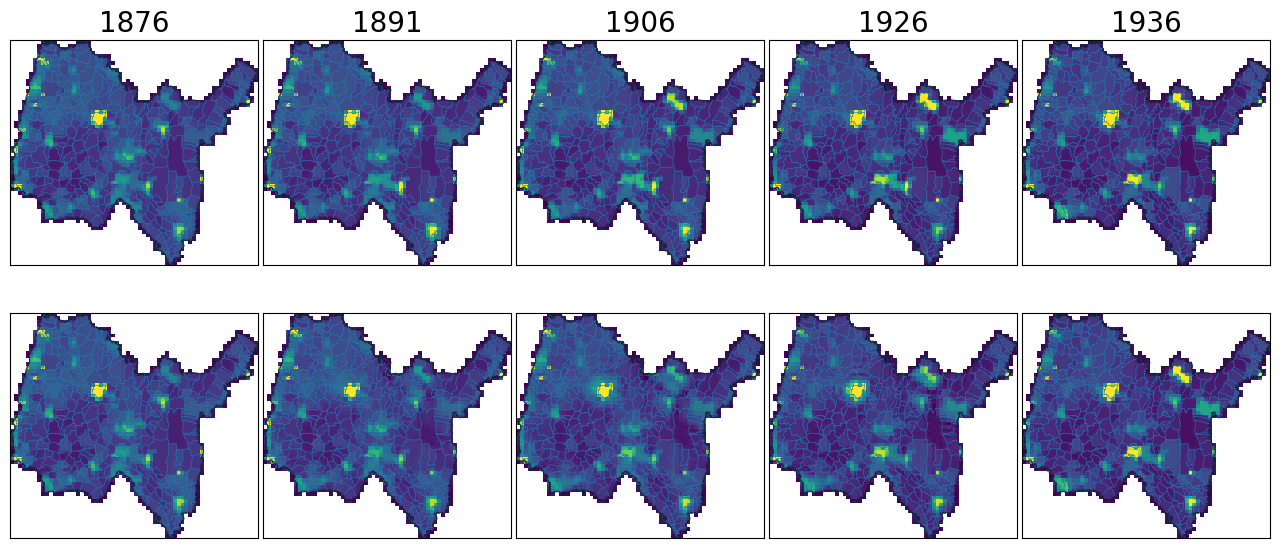

In [16]:
# Plot the geodesic
import numpy as np
import matplotlib.pyplot as plt
X_ot_UD = X_ot.U.D[0]


def figure_true_ot_2row(year_list,
                        equalize_scale=True,
                        robust_pct=99,
                        draw_communes=False,
                        cmap="viridis",
                        dep_lw=0.8,
                        com_lw=0.25,
                        width_per_col=3.0,
                        height_per_row=3.0,
                        panel_labels=False,
                        savepath=None,
                        dpi=300):
    """
    Build a paper-ready figure with two rows:
      Row 1: X_true for each year in `year_list` (columns)
      Row 2: X_ot aligned to those years (columns)
    One shared colorbar on the right.

    Parameters
    ----------
    year_list : list[int]
        Years to show as columns.
    equalize_scale : bool
        If True, uses a single vmax across ALL panels (based on `robust_pct` percentile).
    robust_pct : float
        Percentile for robust color scaling (e.g., 99).
    draw_communes : bool
        Overlay commune borders if `ain_com` is available.
    cmap : str
        Matplotlib colormap (e.g., "viridis", "magma", "plasma").
    dep_lw, com_lw : float
        Line widths for department boundary and commune boundaries.
    width_per_col, height_per_row : float
        Size controls in inches.
    panel_labels : bool
        If True, annotate panels (a), (b), … in row-major order.
    savepath : str | None
        If given, save to this path. Use .pdf or .svg for vector output.
    dpi : int
        DPI when saving to raster formats (PNG, JPG).

    Returns
    -------
    (fig, axes)
    """
    # Expect these to be defined already (per your notebook/script):
    # X_true, X_ot, years, barrier, x_edges, y_edges, ain_dep, ain_com
    global X_true, X_ot_UD, years, barrier, x_edges, y_edges, ain_dep, ain_com

    # --- utilities ---
    def _idx_year(yr):
        if yr not in years.tolist():
            raise ValueError(f"Year {yr} not in available list {years.tolist()}")
        return int(np.where(years == yr)[0][0])

    def _align_true_to_ot(i_true, T_true, T_ot):
        if T_true < 2:
            return 0
        return int(round(i_true * (T_ot - 1) / (T_true - 1)))

    # --- checks ---
    assert X_ot_UD.shape[1:] == X_true.shape[1:], "Grid size mismatch between X_true and X_ot"
    assert len(x_edges) == X_true.shape[2] + 1 and len(y_edges) == X_true.shape[1] + 1, "x_edges/y_edges mismatch"

    # Barrier to boolean mask
    barrier_mask = (barrier > 0.5) if np.issubdtype(barrier.dtype, np.number) else barrier.astype(bool)

    T_true, T_ot = X_true.shape[0], X_ot_UD.shape[0]

    # Gather slices, aligned steps, and values for scaling
    Z_true_list, Z_ot_list, steps = [], [], []
    for yr in year_list:
        i_true = _idx_year(yr)
        i_ot   = _align_true_to_ot(i_true, T_true, T_ot)
        Zt = np.ma.array(X_true[i_true], mask=barrier_mask)
        Zo = np.ma.array(np.clip(X_ot_UD[i_ot], 0, None), mask=barrier_mask)
        Z_true_list.append(Zt); Z_ot_list.append(Zo); steps.append(i_ot)

    # Robust color scale
    vmin = 0.0
    if equalize_scale:
        all_vals = np.concatenate([Z.compressed() for Z in (Z_true_list + Z_ot_list)]) if (Z_true_list or Z_ot_list) else np.array([1.0])
        vmax = np.percentile(all_vals, robust_pct) if all_vals.size else 1.0
    else:
        vmax_true = np.percentile(np.concatenate([Z.compressed() for Z in Z_true_list]), robust_pct)
        vmax_ot   = np.percentile(np.concatenate([Z.compressed() for Z in Z_ot_list]), robust_pct)
        vmax = max(vmax_true, vmax_ot)

    # Figure & axes (2 rows, C columns)
    C = len(year_list)
    fig_w = max(2.0, width_per_col * C)
    fig_h = max(2.0, height_per_row * 2)
    fig, axes = plt.subplots(2, C, figsize=(fig_w, fig_h), squeeze=False)

    # Layout: leave room at right for a tall colorbar
    fig.subplots_adjust(left=0.06, right=0.9, top=0.98, bottom=0.08, wspace=0.02, hspace=0.02)

    # Panel label helper
    def _label(ax, text):
        ax.text(0.01, 0.99, text, transform=ax.transAxes, ha="left", va="top",
                fontsize=10, fontweight="bold",
                bbox=dict(facecolor="white", edgecolor="none", alpha=0.6, pad=2))

    last_pcm = None
    # Row 1: X_true
    for c, (yr, Zt) in enumerate(zip(year_list, Z_true_list)):
        ax = axes[0, c]
        pcm = ax.pcolormesh(x_edges, y_edges, Zt, shading="auto", vmin=vmin, vmax=vmax, cmap=cmap)
        last_pcm = pcm
        if 'ain_dep' in globals() and ain_dep is not None:
            ain_dep.plot(ax=ax, facecolor="none", linewidth=dep_lw)
        if draw_communes and ('ain_com' in globals()) and (ain_com is not None):
            ain_com.boundary.plot(ax=ax, linewidth=com_lw)
        ax.set_aspect("equal")
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(f"{int(yr)}", fontsize=20)
        if c == 0:
            pass
            #ax.set_ylabel("X_true", fontsize=11)
        if panel_labels:
            _label(ax, f"({chr(ord('a') + c)})")

    # Row 2: X_ot
    for c, (Zo, i_ot) in enumerate(zip(Z_ot_list, steps)):
        ax = axes[1, c]
        pcm = ax.pcolormesh(x_edges, y_edges, Zo, shading="auto", vmin=vmin, vmax=vmax, cmap=cmap)
        last_pcm = pcm
        if 'ain_dep' in globals() and ain_dep is not None:
            ain_dep.plot(ax=ax, facecolor="none", linewidth=dep_lw)
        if draw_communes and ('ain_com' in globals()) and (ain_com is not None):
            ain_com.boundary.plot(ax=ax, linewidth=com_lw)
        ax.set_aspect("equal")
        ax.set_xticks([]); ax.set_yticks([])
        # Small caption with OT step count (aligned)
        #ax.set_xlabel(f"OT step {i_ot+1}/{T_ot}", fontsize=9, labelpad=2)
        if c == 0:
            pass
            #ax.set_ylabel("X_ot", fontsize=11)
        if panel_labels:
            _label(ax, f"({chr(ord('a') + C + c)})")

    # Shared vertical colorbar
    if last_pcm is not None:
        pass
        #cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
        #cb = fig.colorbar(last_pcm, cax=cax)
        #cb.set_label("Population per cell", fontsize=10)

    # Save if requested
    if savepath:
        ext = str(savepath).split(".")[-1].lower()
        if ext in ("pdf", "svg"):
            fig.savefig(savepath, bbox_inches="tight")
        else:
            fig.savefig(savepath, dpi=dpi, bbox_inches="tight")

    return fig, axes
# Columns = first year, 1906, last year
fig, axes = figure_true_ot_2row(
    list(years[::3]) + [years[-1]],
    draw_communes=True,
    #panel_labels=True,              # (a), (b), …
    savepath="figures/008-ain-true-vs-ot.png"  # raster output for the paper
)

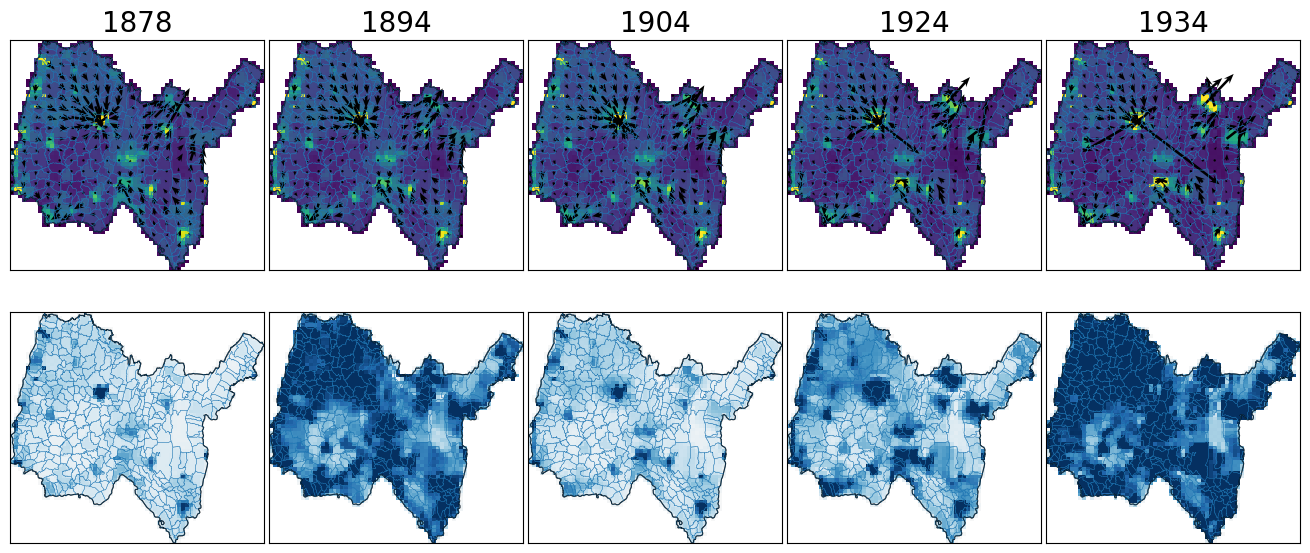

In [ ]:
# Plot the momentum & source
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

def figure_ot_momentum_and_source(
    year_list,
    x,                                 # solution from computeGeodesic with x.V.D, x.V.Z
    quiver_density=0.08,               # fraction of grid used for arrows along each axis (e.g., 0.08 -> every ~12th cell at N=64)
    quiver_scale=None,                 # None => autoscale; set to a float to fix arrow scale
    equalize_scale=True,               # single vmax across all columns (per row)
    robust_pct=99,                     # robust upper percentile for momentum magnitude
    robust_src_pct=99,                 # robust percentile for |source|
    draw_communes=True,                # overlay communes boundaries
    mom_cmap="viridis",                # colormap for momentum magnitude
    src_cmap="RdBu_r",                 # diverging colormap for source (neg=destruction, pos=creation)
    dep_lw=0.8,
    com_lw=0.25,
    width_per_col=3.0,
    height_per_row=3.0,
    panel_labels=False,
    savepath=None,
    dpi=300
):
    """
    Build a figure with two rows:
      Row 1: momentum magnitude (heatmap) + arrows (quiver) for requested years.
      Row 2: source field (creation/destruction) for the same aligned OT steps.

    Parameters
    ----------
    year_list : list[int]
        Years to show as columns (aligned to OT steps via linear mapping).
    x : object
        Solution from computeGeodesic with x.V.D[1], x.V.D[2] (T,N,N) and x.V.Z (T,N,N).
    quiver_density : float
        ~Fraction of grid cells sampled along each axis for quiver arrows (0<d<=1).
    quiver_scale : float or None
        Passed to matplotlib.quiver (scale_units='xy', angles='xy'). None lets Matplotlib autoscale.
    equalize_scale : bool
        If True, uses one vmax for momentum across all panels; and one symmetric vlim for source.
    robust_pct : float
        Percentile to cap momentum magnitude (e.g., 99) to avoid outliers.
    robust_src_pct : float
        Percentile to cap |source| symmetrically around 0.
    draw_communes : bool
        If True and ain_com is available, draw commune boundaries.
    mom_cmap, src_cmap : str
        Colormaps for momentum magnitude and source (diverging).
    dep_lw, com_lw : float
        Line widths for department outline and commune boundaries.
    width_per_col, height_per_row : float
        Size per column/row in inches.
    panel_labels : bool
        Add (a), (b), … labels in row-major order.
    savepath : str | None
        If given, save the figure; raster formats use `dpi`, vector otherwise.
    dpi : int
        Save DPI for raster formats.
    """

    # --------- Expect these globals from your existing notebook/script ----------
    global years, barrier, x_edges, y_edges, ain_dep, ain_com

    # ---- Helper: find or build Ain overlays from available globals ----
    def _resolve_ain_layers():
        dep = globals().get("ain_dep", None)
        com = globals().get("ain_com", None)

        # If neither is defined, try to recover from a likely "ain" communes GeoDataFrame
        if dep is None or com is None:
            if "ain" in globals():
                _ain = globals()["ain"]
                if isinstance(_ain, gpd.GeoDataFrame):
                    if com is None:
                        com = _ain
                    if dep is None and not _ain.empty:
                        dep = gpd.GeoDataFrame(geometry=[_ain.unary_union], crs=_ain.crs)
        return dep, com

    ain_dep_local, ain_com_local = _resolve_ain_layers()

    # ---- Utilities for indexing & alignment (years -> OT step) ----
    years_arr = np.asarray(years, dtype=int)

    def _idx_year(yr):
        idx = np.where(years_arr == int(yr))[0]
        if idx.size == 0:
            raise ValueError(f"Year {yr} not found in available list {years_arr.tolist()}")
        return int(idx[0])

    T_true = len(years_arr)
    T_ot   = int(np.asarray(x.V.Z).shape[0])  # use the source field length as canonical OT T

    def _align_true_to_ot(i_true, T_true, T_ot):
        # Linear alignment of "grid" years to centered OT steps (same mapping you used elsewhere)
        if T_true < 2:
            return 0
        return int(round(i_true * (T_ot - 1) / (T_true - 1)))

    # ---- Barrier to boolean mask ----
    barrier_mask = (barrier > 0.5) if np.issubdtype(np.asarray(barrier).dtype, np.number) else np.asarray(barrier, bool)

    # ---- Extract momentum & source ----
    # User-provided convention: x.V.D[1] -> mx, x.V.D[2] -> my; each (T, N, N)
    mass_full = np.asarray(x.V.D[0])
    Mx_full = np.asarray(x.V.D[2])
    My_full = np.asarray(x.V.D[1])
    Zs_full = np.asarray(x.V.Z)        # (T, N, N)

    assert Mx_full.shape == My_full.shape == Zs_full.shape, \
        f"Shapes must match, got {Mx_full.shape}, {My_full.shape}, {Zs_full.shape}"

    # ---- Build lists for requested years ----
    mass_list, mag_list, U_list, V_list, Zsrc_list, steps = [], [], [], [], [], []
    for yr in year_list:
        i_true = _idx_year(yr)
        i_ot   = _align_true_to_ot(i_true, T_true, T_ot)
        
        mass = np.ma.array(mass_full[i_ot], mask=barrier_mask)
        U = np.ma.array(Mx_full[i_ot], mask=barrier_mask)
        V = np.ma.array(My_full[i_ot], mask=barrier_mask)
        mag = np.ma.sqrt(U**2 + V**2)  # momentum magnitude
        Zs = np.ma.array(Zs_full[i_ot], mask=barrier_mask)

        mass_list.append(mass); U_list.append(U); V_list.append(V); mag_list.append(mag); Zsrc_list.append(Zs); steps.append(i_ot)

    # ---- Robust color scales ----

    
    # Momentum magnitude (>=0)
    if equalize_scale:
        all_mass = np.concatenate([m.compressed() for m in mass_list]) if mass_list else np.array([1.0])
        vmax_mass = float(np.percentile(all_mass, robust_pct)) if all_mass.size else 1.0
    else:
        vmax_mass = max(float(np.percentile(m.compressed(), robust_pct)) for m in mass_list)

    if equalize_scale:
        all_mag = np.concatenate([m.compressed() for m in mag_list]) if mag_list else np.array([1.0])
        vmax_mag = float(np.percentile(all_mag, robust_pct)) if all_mag.size else 1.0
    else:
        vmax_mag = max(float(np.percentile(m.compressed(), robust_pct)) for m in mag_list)

    # Source is signed: symmetric range using |Z|
    if equalize_scale:
        all_absZ = np.concatenate([np.abs(z.compressed()) for z in Zsrc_list]) if Zsrc_list else np.array([1.0])
        vabs_src = float(np.percentile(all_absZ, robust_src_pct)) if all_absZ.size else 1.0
    else:
        vabs_src = max(float(np.percentile(np.abs(z.compressed()), robust_src_pct)) for z in Zsrc_list)

    vmin_mass, vmax_mass = 0.0, (vmax_mass if np.isfinite(vmax_mass) and vmax_mass > 0 else 1.0)
    vmin_mag, vmax_mag = 0.0, (vmax_mag if np.isfinite(vmax_mag) and vmax_mag > 0 else 1.0)
    vmin_src, vmax_src = -vabs_src, +vabs_src

    # ---- Figure & axes ----
    C = len(year_list)
    fig_w = max(2.0, width_per_col * C)
    fig_h = max(2.0, height_per_row * 2)
    fig, axes = plt.subplots(2, C, figsize=(fig_w, fig_h), squeeze=False)
    fig.subplots_adjust(left=0.06, right=0.92, top=0.98, bottom=0.08, wspace=0.02, hspace=0.02)

    # Panel label helper
    def _label(ax, text):
        ax.text(0.01, 0.99, text, transform=ax.transAxes, ha="left", va="top",
                fontsize=10, fontweight="bold",
                bbox=dict(facecolor="white", edgecolor="none", alpha=0.6, pad=2))

    # ---- Coordinates for quiver (cell centers) ----
    # x_edges/y_edges are (N+1); centers are N
    Xc = (x_edges[:-1] + x_edges[1:]) * 0.5
    Yc = (y_edges[:-1] + y_edges[1:]) * 0.5
    XXc, YYc = np.meshgrid(Xc, Yc)  # shape (N, N)

    # Downsample spacing for quiver
    qstep = max(1, int(round(1.0 / float(quiver_density))))  # e.g., 0.08 -> 12
    XXs, YYs = XXc[::qstep, ::qstep], YYc[::qstep, ::qstep]

    # ---- Row 1: Momentum magnitude + arrows ----
    last_pcm_mom = None
    for c, (yr, mass, mag, U, V, i_ot) in enumerate(zip(year_list, mass_list, mag_list, U_list, V_list, steps)):
        ax = axes[0, c]
        pcm = ax.pcolormesh(x_edges, y_edges, mass, shading="auto",
                            vmin=vmin_mass, vmax=vmax_mass, cmap=mom_cmap)
        last_pcm_mom = pcm

        # Overlay department outline and communes
        if ain_dep_local is not None:
            ain_dep_local.plot(ax=ax, facecolor="none", linewidth=dep_lw)
        if draw_communes and (ain_com_local is not None):
            ain_com_local.boundary.plot(ax=ax, linewidth=com_lw)

        # Quiver overlay — mask barrier by setting to nan
        Uq = np.array(U)  # get plain ndarray from masked array
        Vq = np.array(V)
        Uq[barrier_mask] = np.nan
        Vq[barrier_mask] = np.nan

        # Downsample for clarity
        Uqs, Vqs = Uq[::qstep, ::qstep], Vq[::qstep, ::qstep]

        Q = ax.quiver(
            XXs, YYs, Uqs, Vqs,
            angles='xy', scale_units='xy',
            scale=(quiver_scale if quiver_scale is not None else None),
            width=0.01, headwidth=3, headlength=4, headaxislength=3
        )

        ax.set_aspect("equal")
        ax.set_xticks([]); ax.set_yticks([])
        yrs = np.interp([0.5 + i for i in range(11)], range(12), years)
        yrs = np.round(yrs).astype(int)
        ax.set_title(f"{yrs[i_ot]}", fontsize=20)
        if panel_labels:
            _label(ax, f"({chr(ord('a') + c)})")

    # ---- Row 2: Source (creation/destruction) ----
    last_pcm_src = None
    for c, (yr, Zs) in enumerate(zip(year_list, Zsrc_list)):
        ax = axes[1, c]
        pcm = ax.pcolormesh(x_edges, y_edges, Zs, shading="auto",
                            vmin=vmin_src, vmax=vmax_src, cmap=src_cmap)
        last_pcm_src = pcm

        if ain_dep_local is not None:
            ain_dep_local.plot(ax=ax, facecolor="none", linewidth=dep_lw)
        if draw_communes and (ain_com_local is not None):
            ain_com_local.boundary.plot(ax=ax, linewidth=com_lw)

        ax.set_aspect("equal")
        ax.set_xticks([]); ax.set_yticks([])
        if panel_labels:
            _label(ax, f"({chr(ord('a') + C + c)})")

    # ---- Save if requested ----
    if savepath:
        ext = str(savepath).split(".")[-1].lower()
        if ext in ("pdf", "svg"):
            fig.savefig(savepath, bbox_inches="tight")
        else:
            fig.savefig(savepath, dpi=dpi, bbox_inches="tight")

    return fig, axes

# Choose columns similar to your density figure:
cols = list(years[::3]) + [int(years[-1])]

fig, axes = figure_ot_momentum_and_source(
    cols,
    x=X_ot,                      # pass the solution object that has V.D and V.Z
    draw_communes=True,
    quiver_density=0.3,      # a touch sparser arrows; tune as you like (0.06–0.12 works well at N=64)
    robust_pct=99,
    robust_src_pct=80,
    savepath="figures/009-ain-true-vs-ot-momentum-source-delta.png"  # raster output for the paper
)

